In [86]:
# import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
# import zipfile

# from google.colab.patches import cv2_imshow
from keras.callbacks import EarlyStopping
from keras.callbacks import History
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from tensorflow.keras.applications import DenseNet121, EfficientNetB0, InceptionV3, MobileNet, ResNet50, VGG16, VGG19
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [3]:
# path='/content/homer_bart_2.zip'

# zip_obect=zipfile.ZipFile(file=path,mode='r')
# zip_obect.extractall('./')
# zip_obect.close

### Evaluation of different models

In [4]:
models = []
model_names = []
histories = []

#### Preprocessing on train and test datasets

In [48]:
# Define the path to your dataset
dataset_path = 'homer_bart_1'

# Create an ImageDataGenerator for training with data augmentation and validation split
datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split = 0.2)

# Load training data with augmentation
train_generator = datagen.flow_from_directory(dataset_path, target_size = (64, 64), batch_size = 32, class_mode = 'binary', 
                                              subset = 'training', seed = 123)

# Load validation data
validation_generator = datagen.flow_from_directory(dataset_path, target_size = (64, 64), batch_size = 32, class_mode = 'binary', 
                                                   subset = 'validation', seed = 123)

# Load training data with augmentation
train_generator_224 = datagen.flow_from_directory(dataset_path, target_size = (224, 224), batch_size = 32, class_mode = 'binary', 
                                              subset = 'training', seed = 123)

# Load validation data
validation_generator_224 = datagen.flow_from_directory(dataset_path, target_size = (224, 224), batch_size = 32, class_mode = 'binary', 
                                                   subset = 'validation', seed = 123)

# Load training data with augmentation and reduced batch size
train_generator_224_8 = datagen.flow_from_directory(dataset_path, target_size = (224, 224), batch_size = 2, class_mode = 'binary', 
                                              subset = 'training', seed = 123)

# Load validation data
validation_generator_224_8 = datagen.flow_from_directory(dataset_path, target_size = (224, 224), batch_size = 2, class_mode = 'binary', 
                                                   subset = 'validation', seed = 123)

# Load training data with augmentation and reduced batch size
train_generator_299 = datagen.flow_from_directory(dataset_path, target_size = (299, 299), batch_size = 32, class_mode = 'binary', 
                                              subset = 'training', seed = 123)

# Load validation data
validation_generator_299 = datagen.flow_from_directory(dataset_path, target_size = (299, 299), batch_size = 32, class_mode = 'binary', 
                                                   subset = 'validation', seed = 123)

# Create a separate ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Define the path to your test dataset
test_dataset_path = 'test_dataset'

# Load test data
test_generator = test_datagen.flow_from_directory(test_dataset_path, target_size = (64, 64), batch_size = 1, class_mode = 'binary')
test_generator_244 = test_datagen.flow_from_directory(test_dataset_path, target_size = (224, 224), batch_size = 1, class_mode = 'binary')

# Print class indices
print("(64, 64, 3)")
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

print("(224, 224, 3)")
print(train_generator_224.class_indices)
print(validation_generator_224.class_indices)
print(test_generator_244.class_indices)

Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
(64, 64, 3)
{'bart': 0, 'homer': 1}
{'bart': 0, 'homer': 1}
{}
(224, 224, 3)
{'bart': 0, 'homer': 1}
{'bart': 0, 'homer': 1}
{}


## Model Building

### Conv2D Model (Checking)

In [6]:
# Build the model
model_check = Sequential([
    layers.InputLayer(input_shape = (64, 64, 3)),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')  # Output layer for binary classification
])

model_check.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [7]:
# Compile the model
model_check.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
history_check = model_check.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks = [early_stopping])

Epoch 1/100
7/7 [==============================] - 3s 77ms/step - loss: 0.7493 - accuracy: 0.4444 - val_loss: 0.6869 - val_accuracy: 0.6038
Epoch 2/100
7/7 [==============================] - 0s 39ms/step - loss: 0.6871 - accuracy: 0.5972 - val_loss: 0.6675 - val_accuracy: 0.6038
Epoch 3/100
7/7 [==============================] - 0s 40ms/step - loss: 0.6728 - accuracy: 0.5926 - val_loss: 0.6562 - val_accuracy: 0.6038
Epoch 4/100
7/7 [==============================] - 0s 38ms/step - loss: 0.6571 - accuracy: 0.5972 - val_loss: 0.6324 - val_accuracy: 0.6981
Epoch 5/100
7/7 [==============================] - 0s 39ms/step - loss: 0.6316 - accuracy: 0.6528 - val_loss: 0.5955 - val_accuracy: 0.6792
Epoch 6/100
7/7 [==============================] - 0s 38ms/step - loss: 0.6259 - accuracy: 0.6528 - val_loss: 0.5920 - val_accuracy: 0.6792
Epoch 7/100
7/7 [==============================] - 0s 37ms/step - loss: 0.5607 - accuracy: 0.7083 - val_loss: 0.5760 - val_accuracy: 0.7170
Epoch 8/100
7/7 [===

In [8]:
models.append(model_check)
model_names.append("Conv2D Check")
histories.append(history_check)

### Logistic Regression

In [9]:
# Convert data from generators to numpy arrays

def generator_to_numpy(generator):
    images, labels = [], []
    
    for _ in range(len(generator)):
        img_batch, label_batch = next(generator)
        images.extend(img_batch)
        labels.extend(label_batch)
    
    return np.array(images), np.array(labels)

In [10]:
# Get training and validation data as numpy arrays
X_train, y_train = generator_to_numpy(train_generator)
X_val, y_val = generator_to_numpy(validation_generator)

# Flatten images for logistic regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

In [11]:
# Train a Logistic Regression model

logistic_model = LogisticRegression(max_iter=1000)
history_logit = logistic_model.fit(X_train_flat, y_train)

In [12]:
models.append(logistic_model)
model_names.append("Simple Logistic Regression")
histories.append(history_logit)

### Logistic Regression - Scaled

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

In [14]:
# Logistic Regression

logistic_scaled = LogisticRegression(max_iter=2000, solver='lbfgs')
history_logit_scaled = logistic_scaled.fit(X_train_scaled, y_train)

In [15]:
models.append(logistic_scaled)
model_names.append("Scaled Logistic Regression")
histories.append(history_logit_scaled)

### Logistic Regression - SGD

In [16]:
x_train_sgd, x_val_sgd = X_train / 255.0, X_val / 255.0

# Build model
logistic_sgd = Sequential([
    Flatten(input_shape = (64, 64, 3)),
    Dense(1, activation = 'sigmoid')
])

# Compile model
logistic_sgd.compile(optimizer = SGD(), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train model
history_logistic_sgd = logistic_sgd.fit(x_train_sgd, y_train, validation_data=(x_val_sgd, y_val), epochs=100, callbacks = [early_stopping])

Epoch 1/100
7/7 [==============================] - 0s 19ms/step - loss: 0.6931 - accuracy: 0.5185 - val_loss: 0.6927 - val_accuracy: 0.6038
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5926 - val_loss: 0.6920 - val_accuracy: 0.6038
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5926 - val_loss: 0.6913 - val_accuracy: 0.6038
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5926 - val_loss: 0.6906 - val_accuracy: 0.6038
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6906 - accuracy: 0.5926 - val_loss: 0.6900 - val_accuracy: 0.6038
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.5926 - val_loss: 0.6894 - val_accuracy: 0.6038
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.5926 - val_loss: 0.6888 - val_accuracy: 0.6038
Epoch 8/100
7/7 [=========

In [17]:
models.append(logistic_sgd)
model_names.append("Logistic Regression - SGD")
histories.append(history_logistic_sgd)

### SVM Model

In [18]:
# Support Vector Machine
svm_model = SVC()
history_svm = svm_model.fit(X_train_scaled, y_train)

In [19]:
models.append(svm_model)
model_names.append("Support Vector Machine")
histories.append(history_svm)

### MLP 

In [20]:
model_mlp = Sequential([
        Flatten(input_shape = (64, 64, 3)),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ])
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_mlp = model_mlp.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks = [early_stopping])

Epoch 1/100
7/7 [==============================] - 1s 59ms/step - loss: 3.0296 - accuracy: 0.4722 - val_loss: 1.7624 - val_accuracy: 0.6038
Epoch 2/100
7/7 [==============================] - 0s 39ms/step - loss: 1.0745 - accuracy: 0.5185 - val_loss: 0.6079 - val_accuracy: 0.7170
Epoch 3/100
7/7 [==============================] - 0s 43ms/step - loss: 0.8176 - accuracy: 0.5972 - val_loss: 0.7571 - val_accuracy: 0.3962
Epoch 4/100
7/7 [==============================] - 0s 40ms/step - loss: 0.7127 - accuracy: 0.5741 - val_loss: 0.7071 - val_accuracy: 0.5660
Epoch 5/100
7/7 [==============================] - 0s 39ms/step - loss: 0.7922 - accuracy: 0.5370 - val_loss: 0.5849 - val_accuracy: 0.6981
Epoch 6/100
7/7 [==============================] - 0s 37ms/step - loss: 0.6349 - accuracy: 0.6574 - val_loss: 0.5904 - val_accuracy: 0.7170
Epoch 7/100
7/7 [==============================] - 0s 40ms/step - loss: 0.6440 - accuracy: 0.6620 - val_loss: 0.7037 - val_accuracy: 0.6226
Epoch 8/100
7/7 [===

In [21]:
models.append(model_mlp)
model_names.append("Multi Layer Perceptron")
histories.append(history_mlp)

### LeNet-5

In [22]:
lenet_model = Sequential([
        Conv2D(6, (5, 5), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
        Dense(120, activation = 'relu'),
        Dense(84, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ])

lenet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lenet_history = lenet_model.fit(train_generator, validation_data = validation_generator, epochs = 100, callbacks = [early_stopping])

Epoch 1/100
7/7 [==============================] - 1s 68ms/step - loss: 0.8107 - accuracy: 0.5417 - val_loss: 0.6792 - val_accuracy: 0.6038
Epoch 2/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6826 - accuracy: 0.5926 - val_loss: 0.6677 - val_accuracy: 0.6038
Epoch 3/100
7/7 [==============================] - 0s 39ms/step - loss: 0.6732 - accuracy: 0.5926 - val_loss: 0.6611 - val_accuracy: 0.6038
Epoch 4/100
7/7 [==============================] - 0s 40ms/step - loss: 0.6468 - accuracy: 0.5926 - val_loss: 0.6397 - val_accuracy: 0.6038
Epoch 5/100
7/7 [==============================] - 0s 39ms/step - loss: 0.6294 - accuracy: 0.6019 - val_loss: 0.5752 - val_accuracy: 0.6792
Epoch 6/100
7/7 [==============================] - 0s 41ms/step - loss: 0.5773 - accuracy: 0.6852 - val_loss: 0.5761 - val_accuracy: 0.7547
Epoch 7/100
7/7 [==============================] - 0s 38ms/step - loss: 0.5948 - accuracy: 0.6944 - val_loss: 0.6087 - val_accuracy: 0.6792
Epoch 8/100
7/7 [===

In [23]:
models.append(lenet_model)
model_names.append("LeNet - 5")
histories.append(lenet_history)

### AlexNet

In [24]:
alexnet_model = Sequential([
        Conv2D(96, (11, 11), activation = 'relu', strides = (4, 4), input_shape = (224, 224, 3)),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2)),
        Conv2D(256, (5, 5), activation = 'relu', padding = 'same'),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2)),
        Conv2D(384, (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(384, (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2)),
        Flatten(),
        Dense(4096, activation = 'relu'),
        Dropout(0.5),
        Dense(4096, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ])

alexnet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
alexnet_history = alexnet_model.fit(train_generator_224, validation_data = validation_generator_224, epochs = 100, 
                                    callbacks = [early_stopping])

Epoch 1/100
7/7 [==============================] - 6s 580ms/step - loss: 2.7009 - accuracy: 0.5417 - val_loss: 0.6824 - val_accuracy: 0.6038
Epoch 2/100
7/7 [==============================] - 1s 182ms/step - loss: 0.6868 - accuracy: 0.5926 - val_loss: 0.6618 - val_accuracy: 0.6038
Epoch 3/100
7/7 [==============================] - 1s 181ms/step - loss: 0.6733 - accuracy: 0.5926 - val_loss: 0.5761 - val_accuracy: 0.6038
Epoch 4/100
7/7 [==============================] - 1s 171ms/step - loss: 0.6300 - accuracy: 0.5926 - val_loss: 0.5845 - val_accuracy: 0.6038
Epoch 5/100
7/7 [==============================] - 1s 186ms/step - loss: 0.5360 - accuracy: 0.5926 - val_loss: 0.5040 - val_accuracy: 0.6038
Epoch 6/100
7/7 [==============================] - 1s 171ms/step - loss: 0.6841 - accuracy: 0.6944 - val_loss: 0.6286 - val_accuracy: 0.6038
Epoch 7/100
7/7 [==============================] - 1s 171ms/step - loss: 0.6705 - accuracy: 0.5139 - val_loss: 0.6706 - val_accuracy: 0.5849
Epoch 8/100
7

In [25]:
models.append(alexnet_model)
model_names.append("AlexNet")
histories.append(alexnet_history)

### VGG16 (Without Top)

In [26]:
# Load VGG16 model
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build model
vgg_16_model = Sequential([
    base_vgg16,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
vgg_16_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
vgg16_history = vgg_16_model.fit(train_generator_224, validation_data = validation_generator_224, epochs = 100, 
                                    callbacks = [early_stopping])

Epoch 1/100
7/7 [==============================] - 35s 3s/step - loss: 3.7155 - accuracy: 0.4722 - val_loss: 0.6947 - val_accuracy: 0.5094
Epoch 2/100
7/7 [==============================] - 3s 408ms/step - loss: 0.7782 - accuracy: 0.5741 - val_loss: 0.6883 - val_accuracy: 0.6038
Epoch 3/100
7/7 [==============================] - 3s 422ms/step - loss: 0.6815 - accuracy: 0.5602 - val_loss: 0.6947 - val_accuracy: 0.4340
Epoch 4/100
7/7 [==============================] - 4s 473ms/step - loss: 0.6898 - accuracy: 0.5417 - val_loss: 0.6886 - val_accuracy: 0.6038
Epoch 5/100
7/7 [==============================] - 4s 482ms/step - loss: 0.9112 - accuracy: 0.5556 - val_loss: 0.6840 - val_accuracy: 0.6038
Epoch 6/100
7/7 [==============================] - 4s 468ms/step - loss: 0.6958 - accuracy: 0.5556 - val_loss: 0.6858 - val_accuracy: 0.6038
Epoch 7/100
7/7 [==============================] - 4s 479ms/step - loss: 0.6933 - accuracy: 0.5694 - val_loss: 0.6710 - val_accuracy: 0.6038
Epoch 8/100
7/7

In [27]:
models.append(vgg_16_model)
model_names.append("VGG16")
histories.append(vgg16_history)

### VGG19 (Without Top)

In [28]:
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build model
vgg_19_model = Sequential([
    base_vgg19,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
vgg_19_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
vgg19_history = vgg_19_model.fit(train_generator_224, validation_data = validation_generator_224, epochs = 100, 
                                    callbacks = [early_stopping])

Epoch 1/100
7/7 [==============================] - 5s 635ms/step - loss: 9.5842 - accuracy: 0.5556 - val_loss: 0.7196 - val_accuracy: 0.6038
Epoch 2/100
7/7 [==============================] - 4s 549ms/step - loss: 0.7277 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.6038
Epoch 3/100
7/7 [==============================] - 4s 543ms/step - loss: 0.7059 - accuracy: 0.5972 - val_loss: 0.7240 - val_accuracy: 0.3962
Epoch 4/100
7/7 [==============================] - 4s 553ms/step - loss: 0.7062 - accuracy: 0.5417 - val_loss: 0.6849 - val_accuracy: 0.6038
Epoch 5/100
7/7 [==============================] - 4s 551ms/step - loss: 0.6864 - accuracy: 0.5833 - val_loss: 0.6738 - val_accuracy: 0.6038
Epoch 6/100
7/7 [==============================] - 4s 545ms/step - loss: 0.6945 - accuracy: 0.5880 - val_loss: 0.6795 - val_accuracy: 0.6038
Epoch 7/100
7/7 [==============================] - 4s 564ms/step - loss: 0.6872 - accuracy: 0.5926 - val_loss: 0.6811 - val_accuracy: 0.6038
Epoch 8/100
7

In [29]:
models.append(vgg_19_model)
model_names.append("VGG19")
histories.append(vgg19_history)

### VGG16 (With Top)

In [30]:
# Getting resource exhaust error even with batch_size of 2

# # Load VGG16 model
# base_vgg16_2 = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# # Build model
# vgg_16_model_2 = Sequential([
#     base_vgg16_2,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# # Compile model
# vgg_16_model_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# vgg16_history_2 = vgg_16_model_2.fit(train_generator_224_8, validation_data = validation_generator_224_8, epochs = 100, 
#                                     callbacks = [early_stopping])

In [31]:
# models.append(vgg_16_model_2)
# model_names.append("VGG16_2")
# histories.append(vgg16_history_2)

### VGG19 (With Top)

In [32]:
# Getting resource exhaust error even with batch_size of 2

# base_vgg19_2 = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# # Build model
# vgg_19_model_2 = Sequential([
#     base_vgg19_2,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# # Compile model
# vgg_19_model_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# vgg19_history_2 = vgg_19_model_2.fit(train_generator_224_8, validation_data = validation_generator_224_8, epochs = 100, 
#                                     callbacks = [early_stopping])

In [33]:
# models.append(vgg_19_model_2)
# model_names.append("VGG19_2")
# histories.append(vgg19_history_2)

### GoogLe Net (Without Top)

In [34]:
def create_inceptionv3_model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
inceptionv3_model = create_inceptionv3_model(input_shape=(224, 224, 3), num_classes=1)

# Train the model
inceptionv3_history = inceptionv3_model.fit(
    train_generator_224,
    validation_data=validation_generator_224,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
7/7 [==============================] - 11s 831ms/step - loss: 10.5830 - accuracy: 0.5787 - val_loss: 8.7367 - val_accuracy: 0.6226
Epoch 2/100
7/7 [==============================] - 2s 283ms/step - loss: 1.3921 - accuracy: 0.7454 - val_loss: 155.7458 - val_accuracy: 0.6038
Epoch 3/100
7/7 [==============================] - 2s 282ms/step - loss: 0.5775 - accuracy: 0.7870 - val_loss: 77.2508 - val_accuracy: 0.3774
Epoch 4/100
7/7 [==============================] - 2s 280ms/step - loss: 0.3754 - accuracy: 0.8333 - val_loss: 68.7673 - val_accuracy: 0.5283
Epoch 5/100
7/7 [==============================] - 2s 283ms/step - loss: 0.3274 - accuracy: 0.8750 - val_loss: 777.4735 - val_accuracy: 0.6038
Epoch 6/100
7/7 [==============================] - 2s 284ms/step - loss: 0.4929 - accuracy: 0.8750 - val_loss: 1638.6511 - val_accuracy: 0.6038
Epoch 7/100
7/7 [==============================] - 2s 286ms/step - loss: 0.2226 - accuracy: 0.9259 - val_loss: 275.0490 - val_accuracy: 0.6038


In [35]:
models.append(inceptionv3_model)
model_names.append("GoogLe Net")
histories.append(inceptionv3_history)

### ### GoogLe Net (With Top)

In [38]:
# Resource exhaust error, but it worked first time I ran it but over fitting

# def create_inceptionv3_model_top(input_shape, num_classes):
#     base_model = InceptionV3(weights='imagenet', include_top=True, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dropout(0.5)
#         Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# inceptionv3_model_top = create_inceptionv3_model_top(input_shape=(299, 299, 3), num_classes=1)

# # Train the model
# inceptionv3_history_top = inceptionv3_model_top.fit(
#     train_generator_299,
#     validation_data=validation_generator_299,
#     epochs=100,
#     callbacks=[early_stopping]
# )

In [39]:
# models.append(inceptionv3_model_top)
# model_names.append("GoogLe Net (With Top)")
# histories.append(inceptionv3_history_top)

### ResNet-50

In [50]:
# Resource exhaust even with batch_size = 2

# def create_resnet50_model(input_shape, num_classes):
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dropout(0.5),
#         Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# resnet50_model = create_resnet50_model(input_shape=(224, 224, 3), num_classes=1)

# # Train the model
# resnet50_history = resnet50_model.fit(
#     train_generator_224_8,
#     validation_data=validation_generator_224_8,
#     epochs=100,
#     callbacks=[early_stopping]
# )

In [51]:
# models.append(resnet50_model)
# model_names.append("ResNet-50")
# histories.append(resnet50_history)

### ResNet-50 (With Top)

In [52]:
# Resource exhaust even with batch_size = 2

# def create_resnet50_model_top(input_shape, num_classes):
#     base_model = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dropout(0.5),
#         Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# resnet50_model_top = create_resnet50_model_top(input_shape=(224, 224, 3), num_classes=1)

# # Train the model
# resnet50_history_top = resnet50_model_top.fit(
#     train_generator_224_8,
#     validation_data=validation_generator_224_8,
#     epochs=100,
#     callbacks=[early_stopping]
# )

In [53]:
# models.append(resnet50_model_top)
# model_names.append("ResNet-50 (With Top)")
# histories.append(resnet50_history_top)

### MobileNet

In [57]:
# Resource exhaust even with batch_size = 2

# def create_mobilenet_model(input_shape, num_classes):
#     base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# mobilenet_model = create_mobilenet_model(input_shape=(224, 224, 3), num_classes=1)

# # Train the model
# mobilenet_history = mobilenet_model.fit(
#     train_generator_224_8,
#     validation_data=validation_generator_224_8,
#     epochs=100,
#     callbacks=[early_stopping]
# )

In [58]:
# models.append(mobilenet_model)
# model_names.append("MobileNet")
# histories.append(mobilenet_history)

### MobileNet (With Top)

In [59]:
# Resource exhaust even with batch_size = 2

# def create_mobilenet_model_top(input_shape, num_classes):
#     base_model = MobileNet(weights='imagenet', include_top=True, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# mobilenet_model_top = create_mobilenet_model_top(input_shape=(224, 224, 3), num_classes=1)

# # Train the model
# mobilenet_history_top = mobilenet_model_top.fit(
#     train_generator_224_8,
#     validation_data=validation_generator_224_8,
#     epochs=100,
#     callbacks=[early_stopping]
# )

In [60]:
# models.append(mobilenet_model_top)
# model_names.append("MobileNet (With Top)")
# histories.append(mobilenet_history_top)

### DenseNet

In [63]:
def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
densenet_model = create_densenet_model(input_shape=(224, 224, 3), num_classes=1)

# Train the model
densenet_history = densenet_model.fit(
    train_generator_224_8,
    validation_data=validation_generator_224_8,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
108/108 [==============================] - 14s 77ms/step - loss: 17.2525 - accuracy: 0.5648 - val_loss: 24.2041 - val_accuracy: 0.6226
Epoch 2/100
108/108 [==============================] - 7s 67ms/step - loss: 1.3516 - accuracy: 0.6481 - val_loss: 3.2305 - val_accuracy: 0.6038
Epoch 3/100
108/108 [==============================] - 7s 67ms/step - loss: 1.1980 - accuracy: 0.6991 - val_loss: 3.2063 - val_accuracy: 0.5660
Epoch 4/100
108/108 [==============================] - 7s 66ms/step - loss: 0.8626 - accuracy: 0.6667 - val_loss: 0.8859 - val_accuracy: 0.7925
Epoch 5/100
108/108 [==============================] - 7s 66ms/step - loss: 0.6661 - accuracy: 0.7269 - val_loss: 0.5156 - val_accuracy: 0.7547
Epoch 6/100
108/108 [==============================] - 7s 65ms/step - loss: 0.3554 - accuracy: 0.8333 - val_loss: 0.5507 - val_accuracy: 0.8491
Epoch 7/100
108/108 [==============================] - 7s 66ms/step - loss: 0.4471 - accuracy: 0.8194 - val_loss: 0.3364 - val_accura

In [65]:
models.append(densenet_model)
model_names.append("DenseNet")
histories.append(densenet_history)

### DenseNet (With Top)

In [67]:
def create_densenet_model_top(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=True, input_shape=input_shape)
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
densenet_model_top = create_densenet_model_top(input_shape=(224, 224, 3), num_classes=1)

# Train the model
densenet_history_top = densenet_model_top.fit(
    train_generator_224_8,
    validation_data=validation_generator_224_8,
    epochs=100,
    callbacks=[early_stopping]
)

33188688/33188688 [==============================] - 58s 2us/step
Epoch 1/100
108/108 [==============================] - 13s 68ms/step - loss: 0.6775 - accuracy: 0.5926 - val_loss: 0.6761 - val_accuracy: 0.6038
Epoch 2/100
108/108 [==============================] - 6s 58ms/step - loss: 0.6591 - accuracy: 0.6019 - val_loss: 0.6547 - val_accuracy: 0.6226
Epoch 3/100
108/108 [==============================] - 6s 59ms/step - loss: 0.6082 - accuracy: 0.7037 - val_loss: 0.7573 - val_accuracy: 0.6038
Epoch 4/100
108/108 [==============================] - 6s 59ms/step - loss: 0.6639 - accuracy: 0.6389 - val_loss: 0.6763 - val_accuracy: 0.6038
Epoch 5/100
108/108 [==============================] - 6s 59ms/step - loss: 0.6764 - accuracy: 0.5926 - val_loss: 0.6717 - val_accuracy: 0.6038
Epoch 6/100
108/108 [==============================] - 5s 44ms/step - loss: 0.6791 - accuracy: 0.5926 - val_loss: 0.6722 - val_accuracy: 0.6038
Epoch 7/100
108/108 [==============================] - 4s 41ms/step -

In [68]:
models.append(densenet_model_top)
model_names.append("DenseNet (With Top")
histories.append(densenet_history_top)

### EfficientNet

In [73]:
# Resource exhaust even with batch_size = 2

# def create_efficientnet_model(input_shape, num_classes):
#     base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# efficientnet_model = create_efficientnet_model(input_shape=(224, 224, 3), num_classes=1)

# # Train the model
# efficientnet_history = efficientnet_model.fit(
#     train_generator_224_8,
#     validation_data=validation_generator_224_8,
#     epochs=100,
#     callbacks=[early_stopping]
# )

In [74]:
# models.append(efficientnet_model)
# model_names.append("EfficientNet")
# histories.append(efficientnet_history)

In [75]:
### EfficientNet (With Top)

In [76]:
# Resource exhaust even with batch_size = 2

# def create_efficientnet_model_top(input_shape, num_classes):
#     base_model = EfficientNetB0(weights='imagenet', include_top=True, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# efficientnet_model_top = create_efficientnet_model_top(input_shape=(224, 224, 3), num_classes=1)

# # Train the model
# efficientnet_history_top = efficientnet_model_top.fit(
#     train_generator_224_8,
#     validation_data=validation_generator_224_8,
#     epochs=100,
#     callbacks=[early_stopping]
# )

In [77]:
# models.append(efficientnet_model_top)
# model_names.append("EfficientNet (With Top")
# histories.append(efficientnet_history_top)

#### Evaluating the neural netwroks

In [104]:
# Function to evaluate a model and return metrics
def evaluate_model(model, validation_generator):
    # Evaluate the model on the validation data
    val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
    
    # Predict on validation data
    val_steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
    predictions = model.predict(validation_generator, steps=val_steps)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    true_classes = validation_generator.classes
    
    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Generate classification report
    class_report = classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys(), output_dict=True)
    
    return {
        'loss': val_loss,
        'accuracy': val_accuracy,
        'confusion_matrix': cm,
        'classification_report': class_report
    }

# Function to plot validation loss and accuracy
def plot_metrics(histories, model_names):
    """
    Plot validation loss and accuracy for multiple models.

    Args:
    histories (list): List of history objects for each model.
    model_names (list): List of model names for plotting legend.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot validation loss for all models
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_loss'], label=f'Validation Loss ({name})')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation accuracy for all models
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy ({name})')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'history'

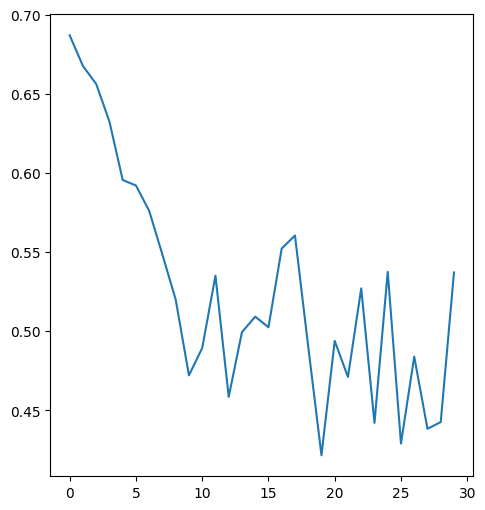

In [105]:
plot_metrics(histories, model_names)

In [106]:
evaluate_model(models, validation_generator_224)

AttributeError: 'list' object has no attribute 'evaluate'

In [107]:
plot_confusion_matrix(cm, class_names, model_name)

NameError: name 'cm' is not defined

In [108]:
def plot_metrics(histories, model_names):
    """
    Plot validation loss and accuracy for multiple Keras models.

    Args:
    histories (list): List of history objects for each Keras model.
    model_names (list): List of model names for plotting legend.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot validation loss for all models
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_loss'], label=f'Validation Loss ({name})')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation accuracy for all models
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy ({name})')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [109]:
def plot_metrics(metrics_dict, model_names):
    """
    Plot metrics for multiple models.

    Args:
    metrics_dict (dict): Dictionary where keys are model names and values are dictionaries with 'val_loss' and 'val_accuracy'.
    model_names (list): List of model names for plotting legend.
    """
    plt.figure(figsize=(12, 6))

    # Plot validation loss for all models
    plt.subplot(1, 2, 1)
    for name in model_names:
        metrics = metrics_dict.get(name, {})
        plt.plot(metrics.get('epochs', []), metrics.get('val_loss', []), label=f'Validation Loss ({name})')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy for all models
    plt.subplot(1, 2, 2)
    for name in model_names:
        metrics = metrics_dict.get(name, {})
        plt.plot(metrics.get('epochs', []), metrics.get('val_accuracy', []), label=f'Validation Accuracy ({name})')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [110]:
def evaluate_models(models, validation_generator):
    results = {}
    for model in models:
        # Evaluate the model on the validation data
        val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
        
        # Predict on validation data
        val_steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
        predictions = model.predict(validation_generator, steps=val_steps)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Get true labels
        true_classes = validation_generator.classes
        
        # Generate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        
        # Generate classification report
        class_report = classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys(), output_dict=True)
        
        results[model] = {
            'loss': val_loss,
            'accuracy': val_accuracy,
            'confusion_matrix': cm,
            'classification_report': class_report
        }
    return results


In [115]:
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()

for metrics in histories:
    plot_confusion_matrix(metrics, class_names, model_name)


ValueError: Must pass 2-d input. shape=()

<Figure size 800x600 with 0 Axes>